# 1. Preparation
This version runs in the Google Colab, ignore the first three cells if running the notebook locally.

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
%cd /content/drive/MyDrive/house-prices-advanced-regression-techniques

/content/drive/MyDrive/house-prices-advanced-regression-techniques


In [82]:
!pwd

/content/drive/MyDrive/house-prices-advanced-regression-techniques


In [83]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
import os

warnings.filterwarnings('ignore')
%matplotlib inline

os.getcwd()

'/content/drive/MyDrive/house-prices-advanced-regression-techniques'

In [84]:
# Load the training and test data
train_data_path = 'train.csv'
test_data_path = 'test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [85]:
# Check the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [86]:
# Check the test dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

# 2. EDA

## 2.1 Explore the Label SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


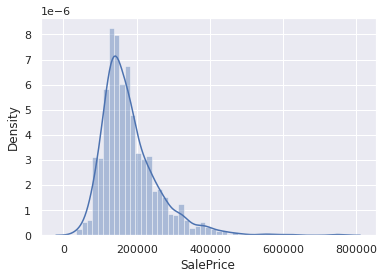

In [87]:
# Descriptive statistics summary
print(train_data['SalePrice'].describe())

# histogramm for SalePrice
sns.distplot(train_data['SalePrice'])
plt.show()

In [88]:
# Skewness and kurtosis
print('Skewness: %f' % train_data['SalePrice'].skew())
print('Kurtosis: %f' % train_data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 2.2 Explore the Whole Features

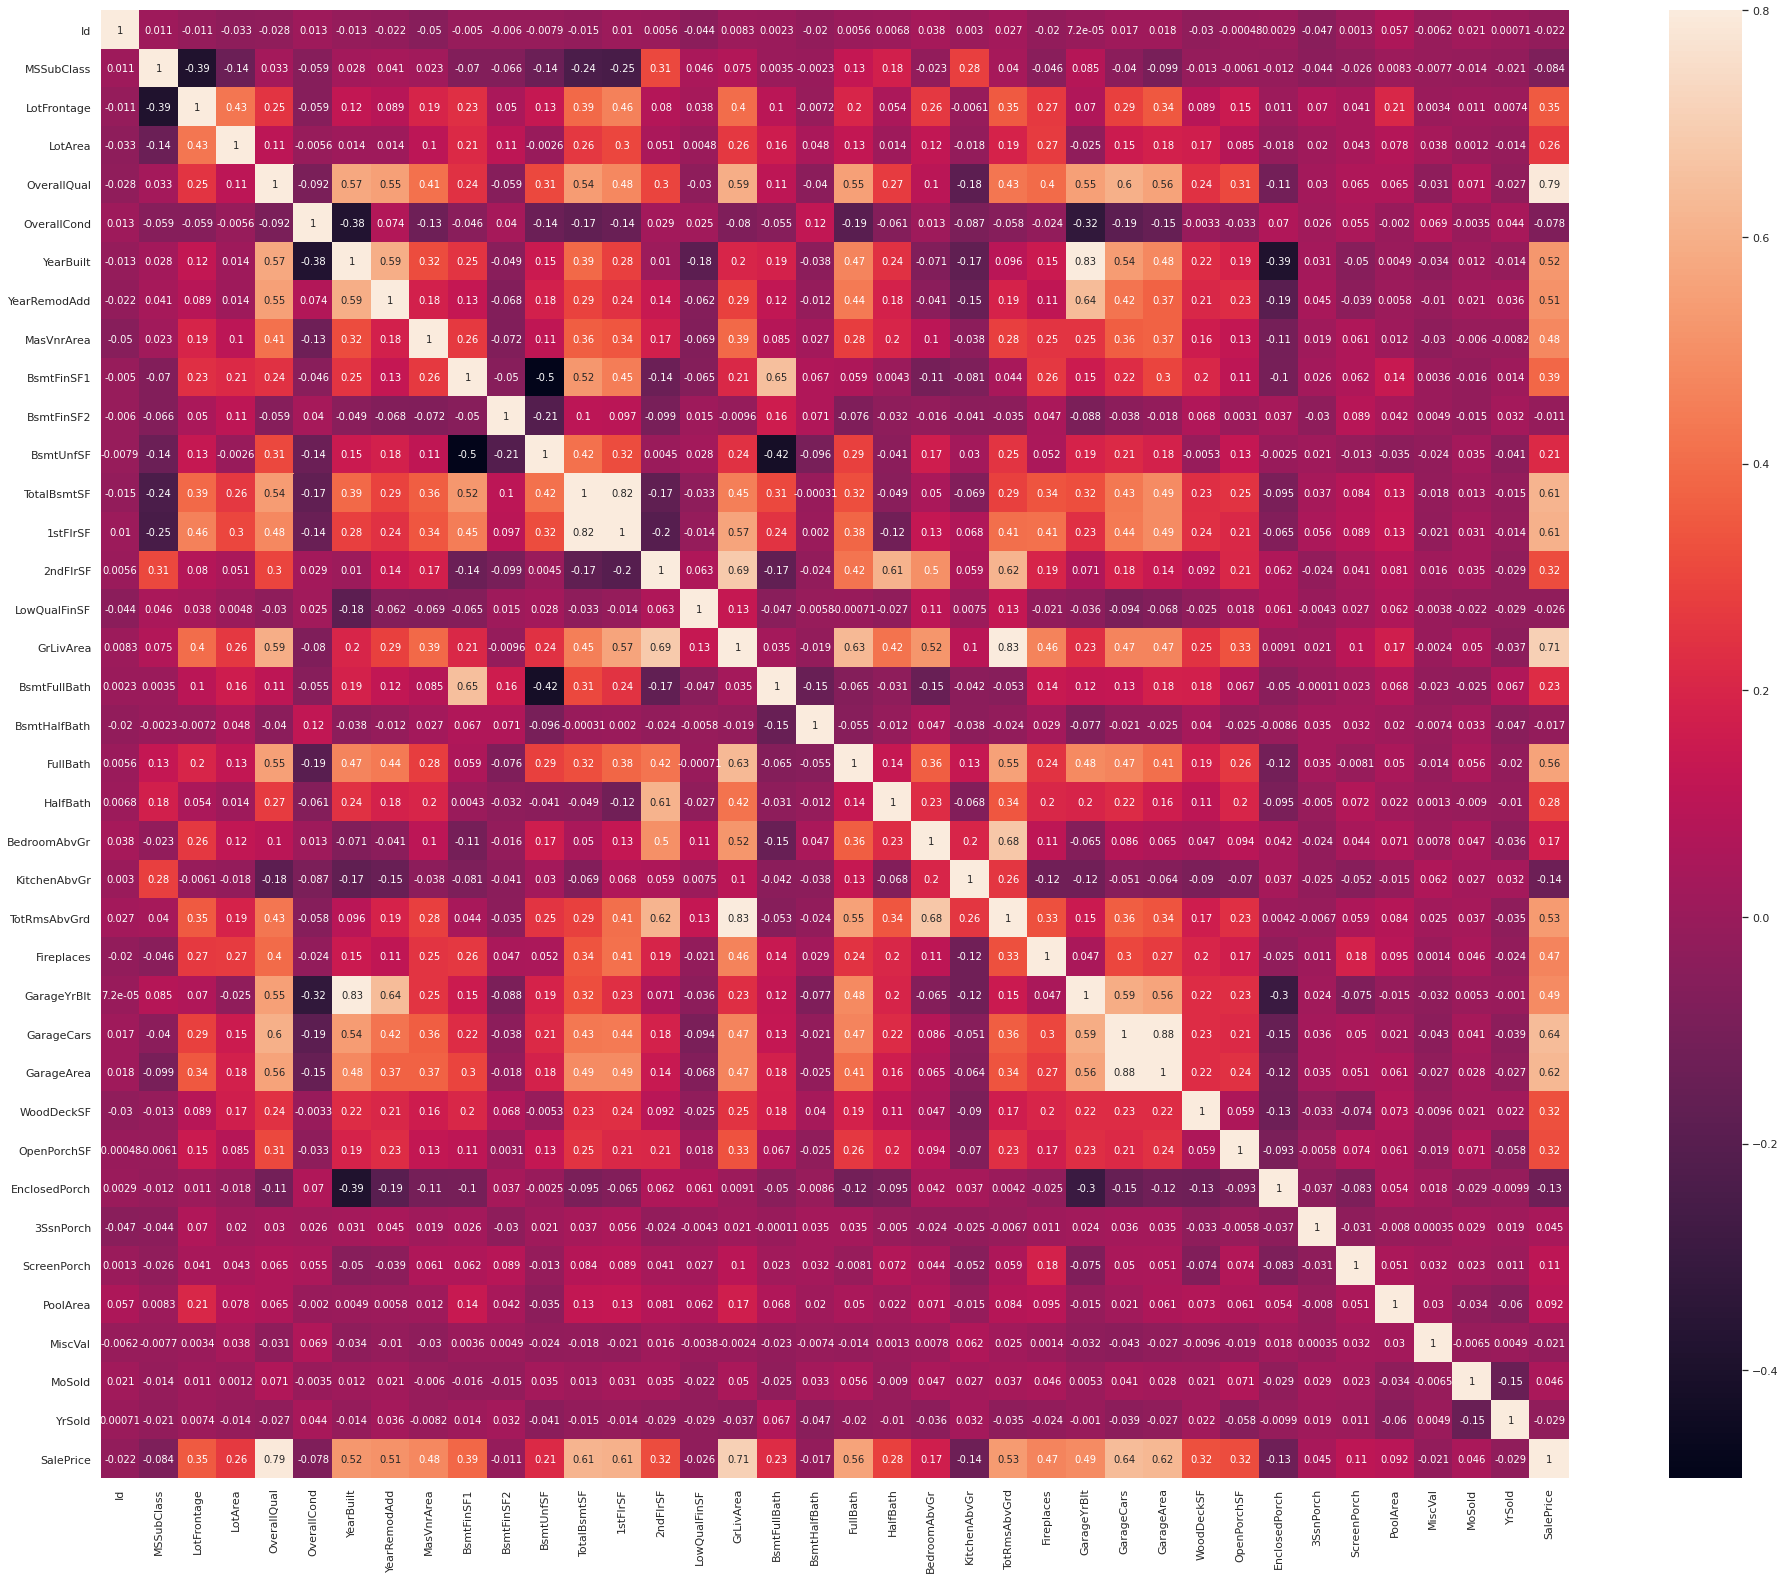

In [89]:
# Correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize = (36, 27))
sns.heatmap(corrmat, vmax = .8, square = True, annot = True)
plt.show()

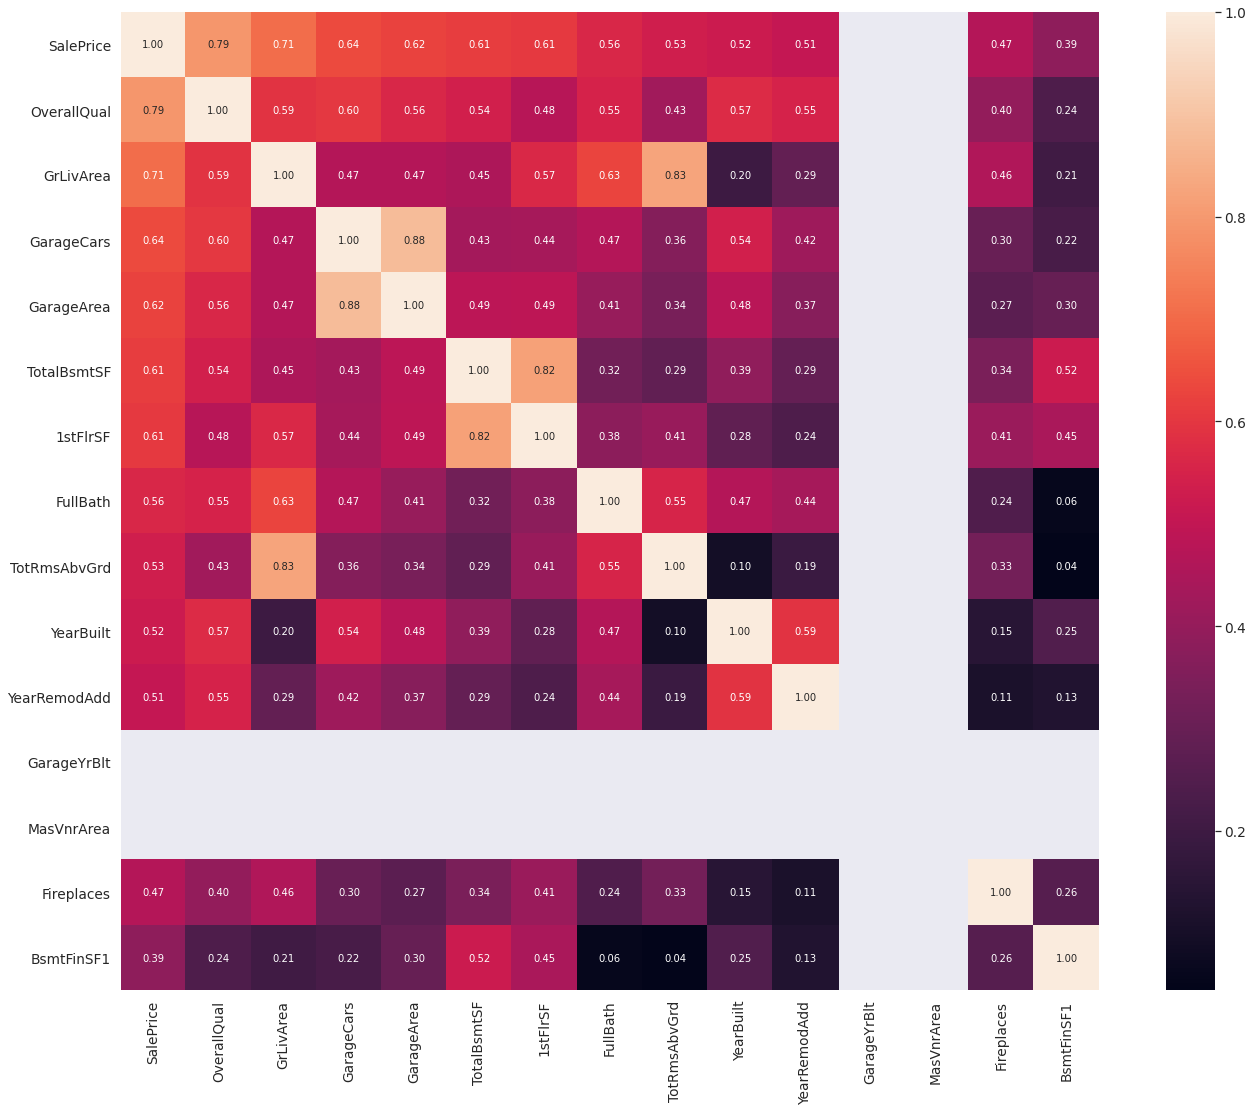

In [90]:
# SalePrice correlation Matrix
# 20 largest correlation pairs

def k_largest_corr(corrmat, k=20):
    '''
    :param corrmat: correlation matrix as input
    :param k: num of variables in the heatmap
    :return: 
    '''

    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize = (24, 18))
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                     xticklabels=cols.values)
    plt.show()


k_largest_corr(corrmat, k=15)

## 2.2.1 Explore the Numerical Features

In [91]:
# Select the numeric features
numeric = [cname for cname in train_data.columns[1:] if train_data[cname].dtype in ['int64', 'float64']]

for i, feature in enumerate(list(train_data[numeric]), 1):
    print(i, feature)

1 MSSubClass
2 LotFrontage
3 LotArea
4 OverallQual
5 OverallCond
6 YearBuilt
7 YearRemodAdd
8 MasVnrArea
9 BsmtFinSF1
10 BsmtFinSF2
11 BsmtUnfSF
12 TotalBsmtSF
13 1stFlrSF
14 2ndFlrSF
15 LowQualFinSF
16 GrLivArea
17 BsmtFullBath
18 BsmtHalfBath
19 FullBath
20 HalfBath
21 BedroomAbvGr
22 KitchenAbvGr
23 TotRmsAbvGrd
24 Fireplaces
25 GarageYrBlt
26 GarageCars
27 GarageArea
28 WoodDeckSF
29 OpenPorchSF
30 EnclosedPorch
31 3SsnPorch
32 ScreenPorch
33 PoolArea
34 MiscVal
35 MoSold
36 YrSold
37 SalePrice


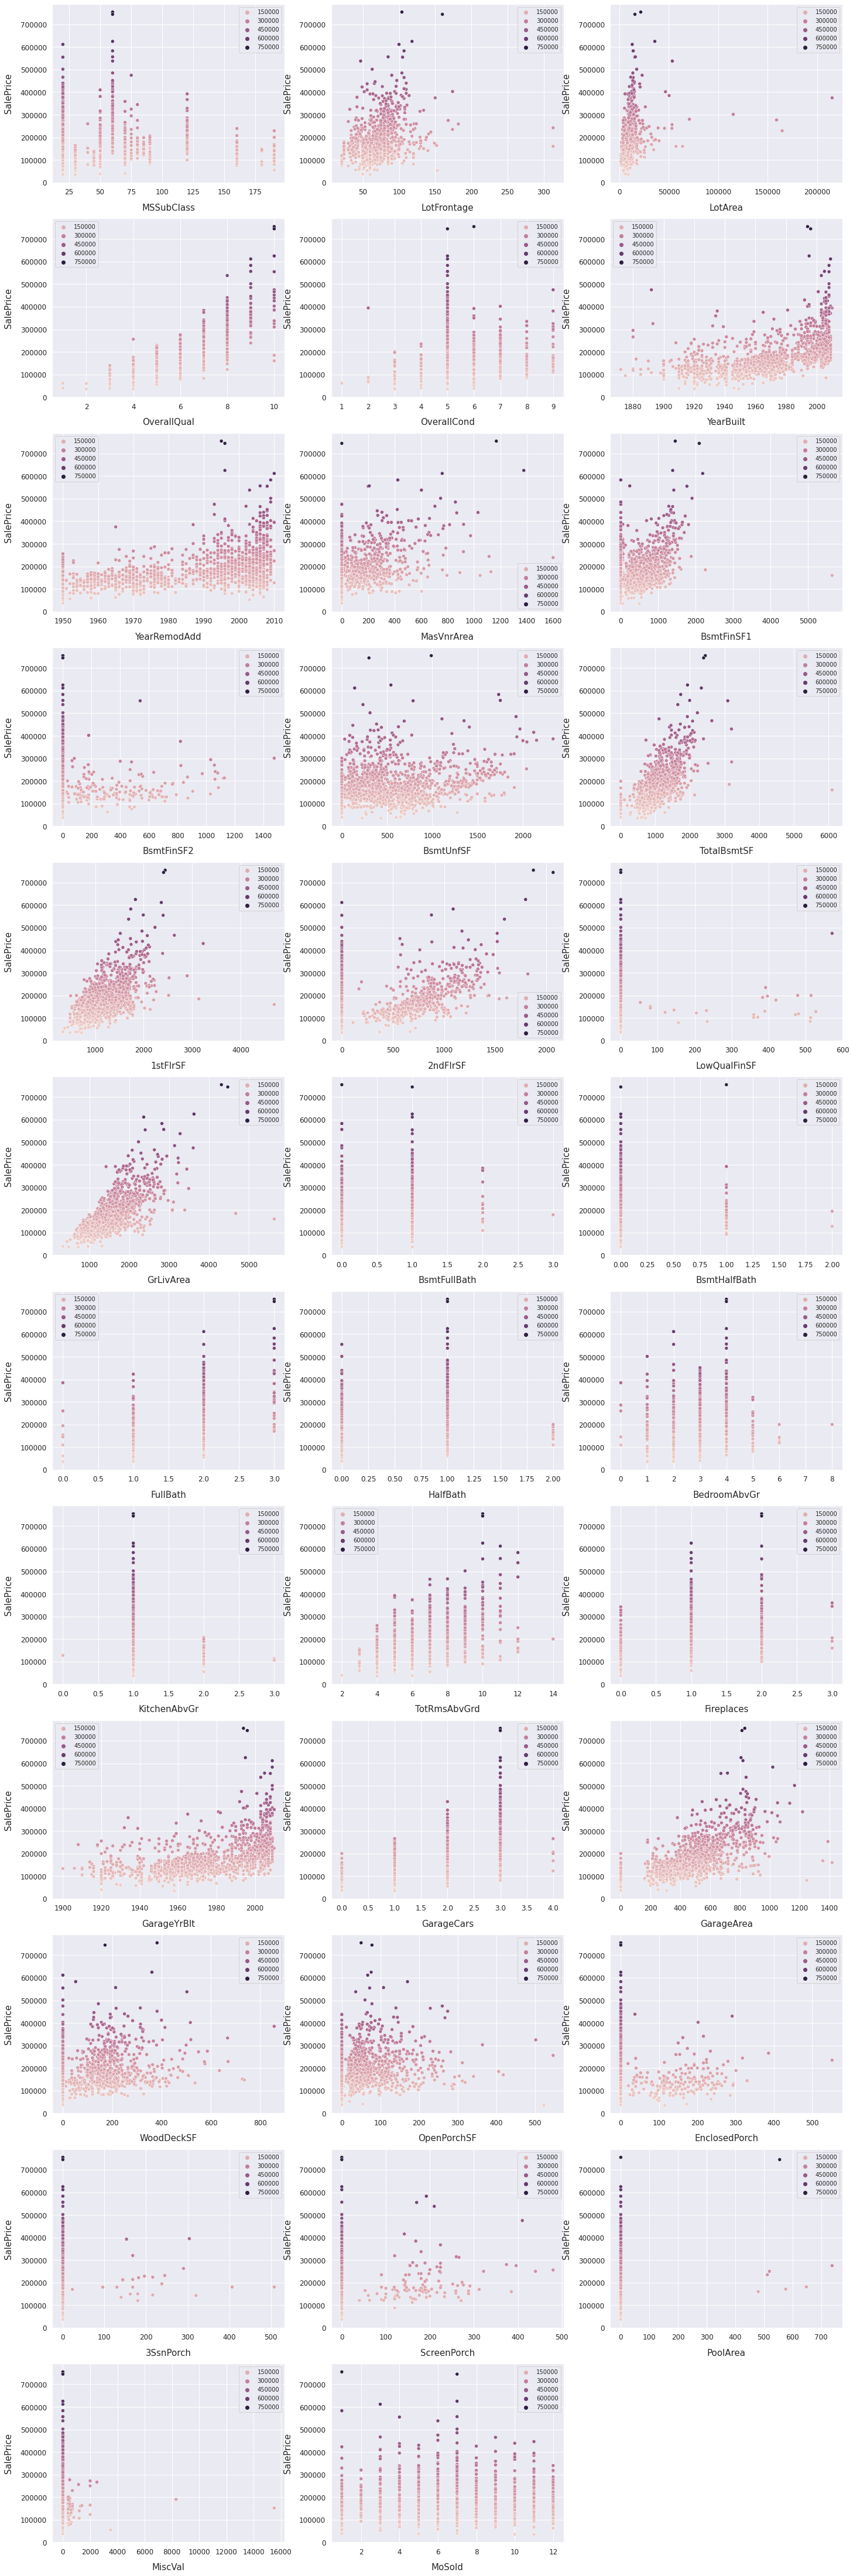

In [92]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=1,  figsize=(10, 100))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
#sns.color_palette("husl", 8)
for i, feature in enumerate(list(train_data[numeric]), 1):
    if(feature=='YrSold'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue = 'SalePrice',  data=train_data)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

## 2.2.2 Explore the Categorical Features

In [93]:
# Select the categorical features
categorical = [cname for cname in train_data.columns[1:] if train_data[cname].dtype == 'object']

for i, feature in enumerate(list(train_data[categorical]), 1):
    print(i, feature)

1 MSZoning
2 Street
3 Alley
4 LotShape
5 LandContour
6 Utilities
7 LotConfig
8 LandSlope
9 Neighborhood
10 Condition1
11 Condition2
12 BldgType
13 HouseStyle
14 RoofStyle
15 RoofMatl
16 Exterior1st
17 Exterior2nd
18 MasVnrType
19 ExterQual
20 ExterCond
21 Foundation
22 BsmtQual
23 BsmtCond
24 BsmtExposure
25 BsmtFinType1
26 BsmtFinType2
27 Heating
28 HeatingQC
29 CentralAir
30 Electrical
31 KitchenQual
32 Functional
33 FireplaceQu
34 GarageType
35 GarageFinish
36 GarageQual
37 GarageCond
38 PavedDrive
39 PoolQC
40 Fence
41 MiscFeature
42 SaleType
43 SaleCondition


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

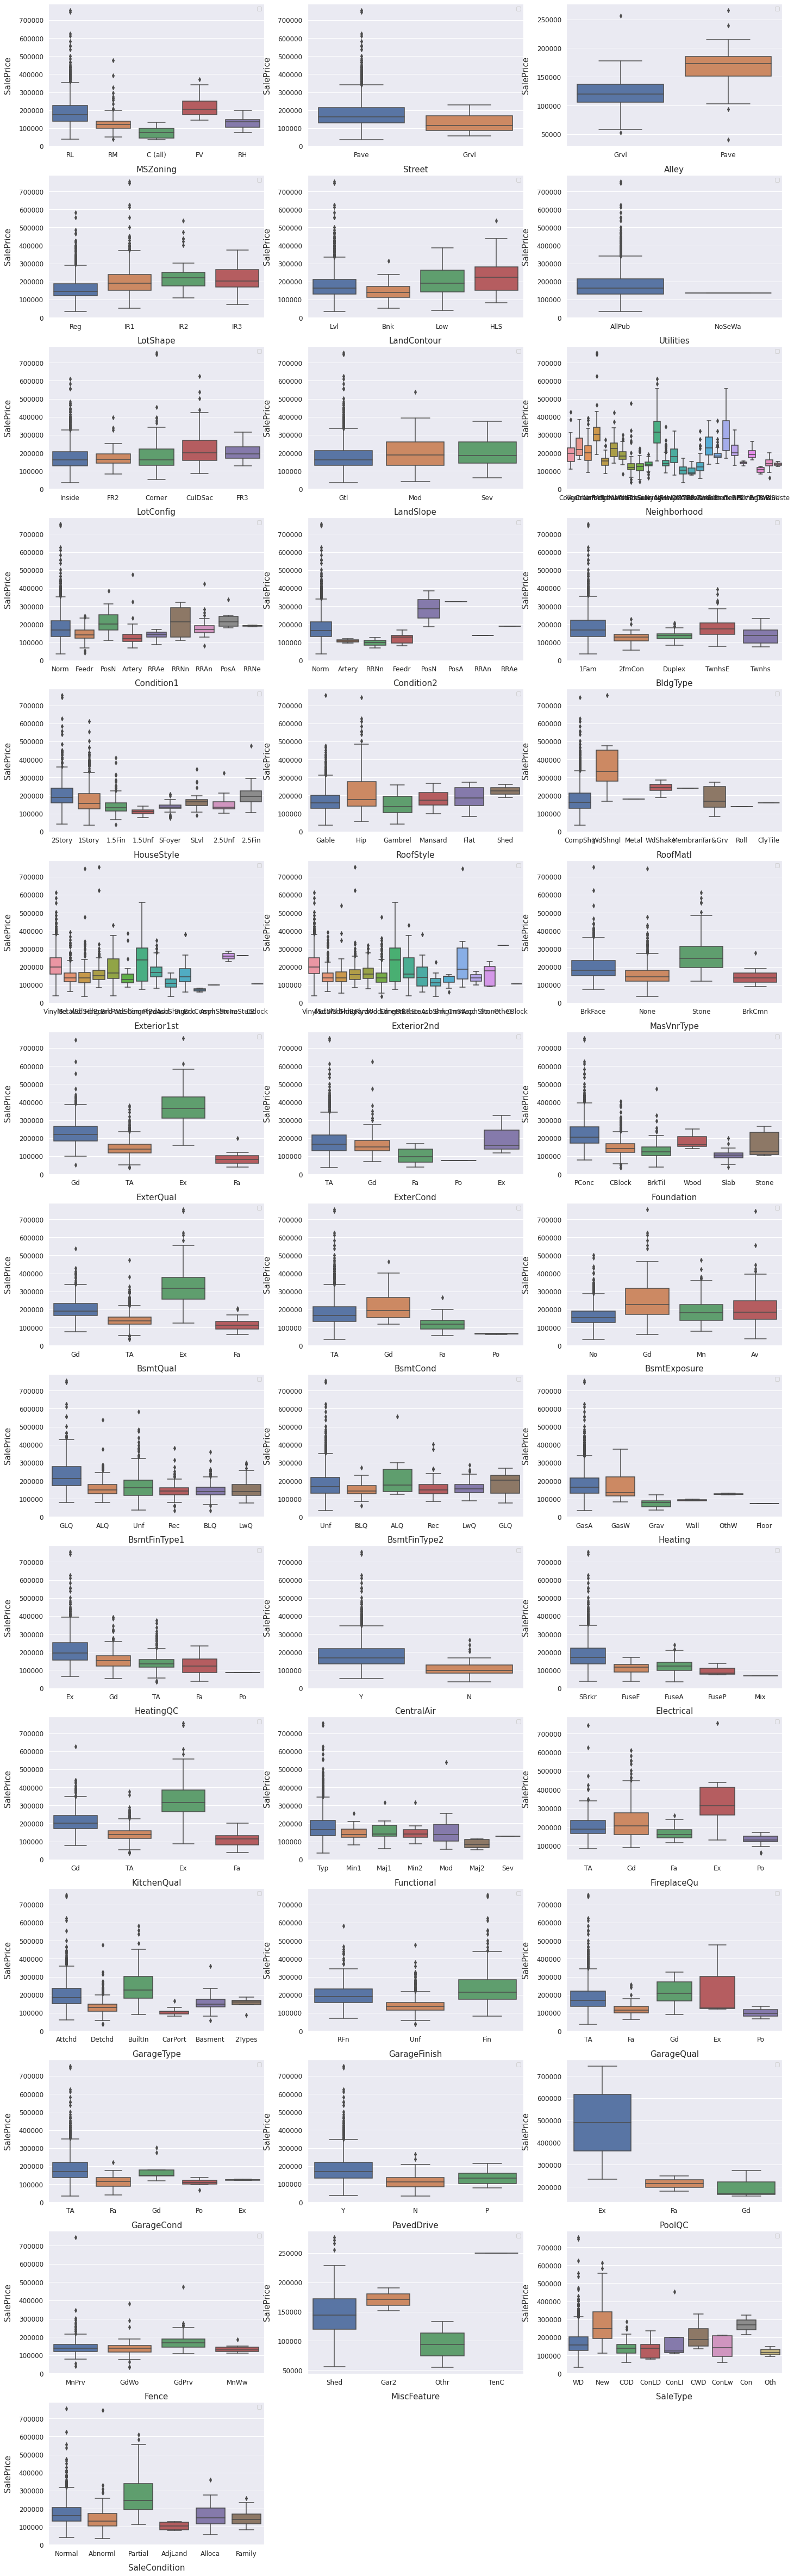

In [94]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=1,  figsize=(10, 100))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
#sns.color_palette("husl", 8)
for i, feature in enumerate(list(train_data[categorical]), 1):
#    if(feature=='YrSold'):
#        break
    plt.subplot(len(list(categorical)), 3, i)
    sns.boxplot(x=feature, y='SalePrice', data=train_data)
        
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

(-0.5, 9.5, 0.0, 800000.0)

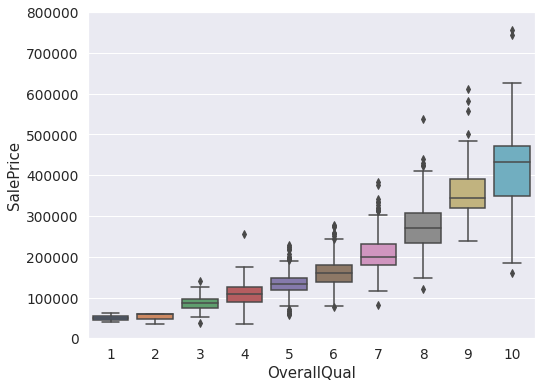

In [95]:
# box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x = var, y = 'SalePrice', data = data)
fig.axis(ymin = 0, ymax = 800000)

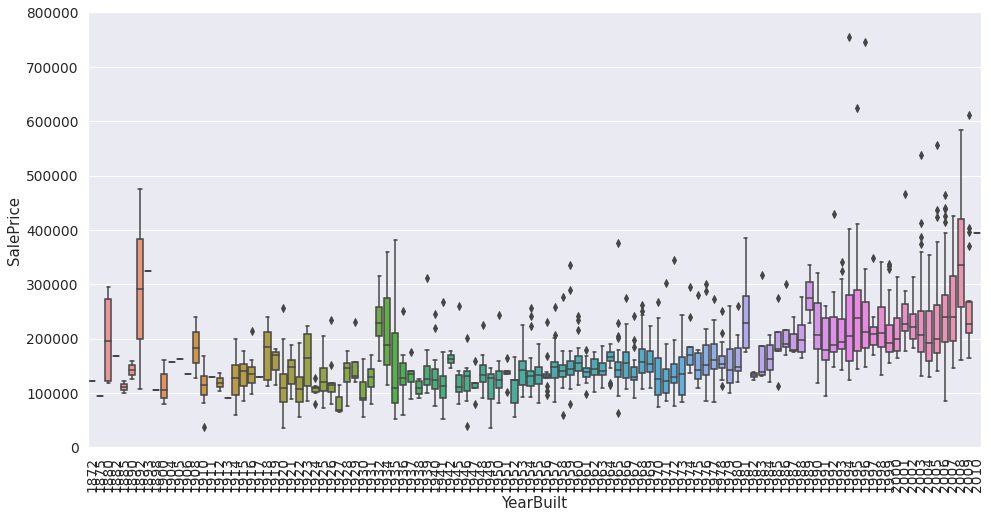

In [96]:
var = 'YearBuilt'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

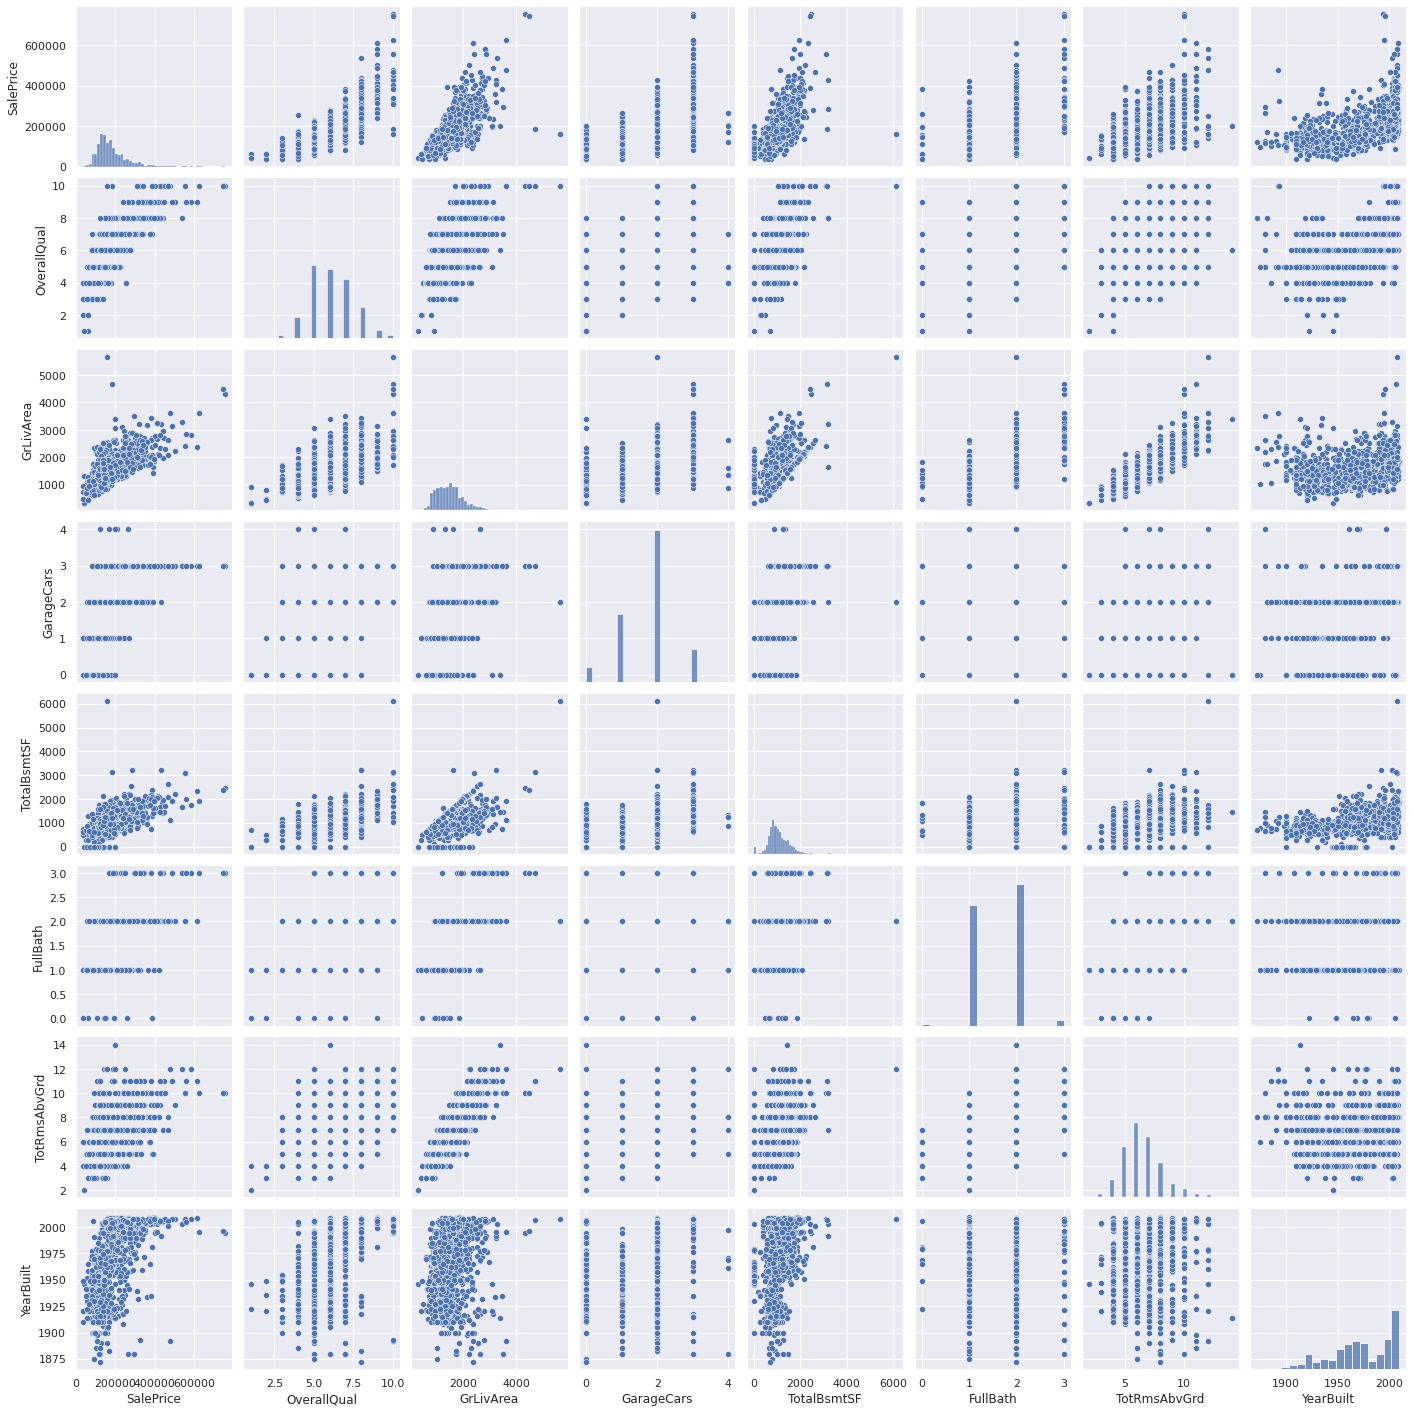

In [97]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(train_data[cols], size = 2.5)
plt.show()

# 3. Feature Engineering

## 3.1 Deleting some Features to avoid Multicolinearity

In [98]:
# Delete certain features to avoid multicollinearity
def delete_feature(data):
    
    data = data.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageArea'], axis = 1)

    return data

# Concatenate the train and test dataset
train_data['TrainTest'] = 1
test_data['TrainTest'] = 0
data = pd.concat([train_data, test_data]).reset_index(drop=True)
data = delete_feature(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

##  3.2 Handling the Missing Values
Handling the training data and test data seperately to avoid data leakage!

In [99]:
# Show the missing data amount and type
def show_missing(data):
    # Total missing values
    total = data.isnull().sum()
    
    # Percentage of missing values
    percent = 100 * data.isnull().sum() / data.isnull().count()
    
    # Make a table to show the results
    mis_data = pd.concat([total, percent], axis = 1, keys = ['Missing Values', '% of Total Values'])
    
    # Sort the values
    mis_data = mis_data[mis_data.iloc[:, 1] != 0].sort_values('% of Total Values', ascending = False)
    
    # Print the summary
    # Number of rows are in the training data?
    num_rows = data.shape[0]

    # Number of columns with missing data in the training data
    num_cols_with_missing = data.isnull().any().sum()

    # Number of missing entries in the training data?
    tot_missing = data.isnull().sum().sum()

    print('Number of rows: {},\nNumber of columns with missing data: {}\nNumber of total missing entries: {}'
          .format(num_rows, num_cols_with_missing, tot_missing))
    
    return mis_data
    
show_missing(data)

Number of rows: 2919,
Number of columns with missing data: 33
Number of total missing entries: 15264


Missing Values  % of Total Values
PoolQC                  2909          99.657417
MiscFeature             2814          96.402878
Alley                   2721          93.216855
Fence                   2348          80.438506
SalePrice               1459          49.982871
FireplaceQu             1420          48.646797
LotFrontage              486          16.649538
GarageCond               159           5.447071
GarageFinish             159           5.447071
GarageQual               159           5.447071
GarageType               157           5.378554
BsmtExposure              82           2.809181
BsmtCond                  82           2.809181
BsmtQual                  81           2.774923
BsmtFinType2              80           2.740665
BsmtFinType1              79           2.706406
MasVnrType                24           0.822199
MasVnrArea                23           0.787941
MSZoning                   4           0.137033
BsmtHalfBath               2           0.068517
Functional                 2           0.068517
BsmtFullBath               2           0.068517
Utilities                  2           0.068517
KitchenQual                1           0.034258
Electrical                 1           0.034258
BsmtUnfSF                  1           0.034258
GarageCars                 1           0.034258
BsmtFinSF2                 1           0.034258
BsmtFinSF1                 1           0.034258
Exterior2nd                1           0.034258
Exterior1st                1           0.034258
SaleType                   1           0.034258
TotalBsmtSF                1           0.034258

In [100]:
# Show the missing values of training dataset
show_missing(data[data['TrainTest']==1])

Number of rows: 1460,
Number of columns with missing data: 18
Number of total missing entries: 6884


Missing Values  % of Total Values
PoolQC                  1453          99.520548
MiscFeature             1406          96.301370
Alley                   1369          93.767123
Fence                   1179          80.753425
FireplaceQu              690          47.260274
LotFrontage              259          17.739726
GarageType                81           5.547945
GarageFinish              81           5.547945
GarageQual                81           5.547945
GarageCond                81           5.547945
BsmtExposure              38           2.602740
BsmtFinType2              38           2.602740
BsmtFinType1              37           2.534247
BsmtCond                  37           2.534247
BsmtQual                  37           2.534247
MasVnrArea                 8           0.547945
MasVnrType                 8           0.547945
Electrical                 1           0.068493

In [101]:
show_missing(data[data['TrainTest'] == 0])

Number of rows: 1459,
Number of columns with missing data: 32
Number of total missing entries: 8380


Missing Values  % of Total Values
SalePrice               1459         100.000000
PoolQC                  1456          99.794380
MiscFeature             1408          96.504455
Alley                   1352          92.666210
Fence                   1169          80.123372
FireplaceQu              730          50.034270
LotFrontage              227          15.558602
GarageCond                78           5.346127
GarageFinish              78           5.346127
GarageQual                78           5.346127
GarageType                76           5.209047
BsmtCond                  45           3.084304
BsmtExposure              44           3.015764
BsmtQual                  44           3.015764
BsmtFinType1              42           2.878684
BsmtFinType2              42           2.878684
MasVnrType                16           1.096642
MasVnrArea                15           1.028101
MSZoning                   4           0.274160
Functional                 2           0.137080
BsmtHalfBath               2           0.137080
BsmtFullBath               2           0.137080
Utilities                  2           0.137080
KitchenQual                1           0.068540
BsmtUnfSF                  1           0.068540
GarageCars                 1           0.068540
BsmtFinSF2                 1           0.068540
BsmtFinSF1                 1           0.068540
Exterior2nd                1           0.068540
Exterior1st                1           0.068540
SaleType                   1           0.068540
TotalBsmtSF                1           0.068540

In [103]:
# Handle the missing data, two methods are proposed here for testing
# Method 1: fill the missing values with None
def handle_missing(data):
    data['PoolQC'].fillna('None', inplace = True)
    data['MiscFeature'].fillna('None', inplace = True)
    data['Alley'].fillna('None', inplace = True)
    data['Fence'].fillna('None', inplace = True)
    data['FireplaceQu'].fillna('None', inplace = True)
    data['LotFrontage'].fillna('None', inplace = True)
    data['GarageCond'].fillna('None', inplace = True)
    data['GarageFinish'].fillna('None', inplace = True)
    data['GarageQual'].fillna('None', inplace = True)
    data['GarageType'].fillna('None', inplace = True)
    data['BsmtFinType2'].fillna('None', inplace = True)
    data['BsmtExposure'].fillna('None', inplace = True)
    data['BsmtQual'].fillna('None', inplace = True)
    data['BsmtCond'].fillna('None', inplace = True)
    data['BsmtFinType1'].fillna('None', inplace = True)
    data['MasVnrArea'].fillna(0, inplace = True) # integer
    data['MasVnrType'].fillna('None', inplace = True)
    data['Electrical'].fillna('None', inplace = True)
    
    return data

# Method 2: drop the columns with more than 90% missing values and fill the other columns with different strategies
def handle_missing_2(data):
    data.drop('PoolQC', axis = 1, inplace = True)
    data.drop('MiscFeature', axis = 1, inplace = True)
    data.drop('Alley', axis = 1, inplace = True)
    
    data['Fence'].fillna('None', inplace = True)
    
    # NA in FireplaceQu means No Fireplace
    data['FireplaceQu'].fillna('None', inplace = True)
    
    data['LotFrontage'].fillna('None', inplace = True)
    
    data['GarageCond'].fillna('None', inplace = True)
    data['GarageFinish'].fillna('None', inplace = True)
    data['GarageQual'].fillna('None', inplace = True)
    data['GarageType'].fillna('None', inplace = True)
    
    data['BsmtFinType2'].fillna('None', inplace = True)
    data['BsmtExposure'].fillna('None', inplace = True)
    data['BsmtQual'].fillna('None', inplace = True)
    data['BsmtCond'].fillna('None', inplace = True)
    data['BsmtFinType1'].fillna('None', inplace = True)
    
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        data[col] = data[col].fillna(0)
    
    data['MasVnrArea'].fillna(0, inplace = True)
    data['MasVnrType'].fillna('None', inplace = True)
    
    # Fill the missing value in Electrical with the mode of TRAING DATA!
    data['Electrical'].fillna(data[data['TrainTest']==1]['Electrical'].mode()[0], inplace = True)
    
    return data

#data = pd.concat([train_data, test_data]).reset_index(drop=True)
#data = handle_missing(data)

In [104]:
# Show the data after handling missing values
data1 = data.copy()

data2 = handle_missing_2(data1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2919 non-null   object 
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [105]:
# Show the missing values in the test dataset
test = data2[data2['TrainTest'] == 0]
show_missing(test)

Number of rows: 1459,
Number of columns with missing data: 9
Number of total missing entries: 1472


Missing Values  % of Total Values
SalePrice              1459          100.00000
MSZoning                  4            0.27416
Utilities                 2            0.13708
Functional                2            0.13708
Exterior1st               1            0.06854
Exterior2nd               1            0.06854
KitchenQual               1            0.06854
GarageCars                1            0.06854
SaleType                  1            0.06854

In [106]:
# Show the missing values in the test dataset
test = data2[data2['TrainTest'] == 0]
mis_data_test = show_missing(test)

# Show the types of the columns with missing values
print('\nthe dtype of the feature with missing values: \n')
for item in mis_data_test.index.values:
    print(item + ': ', test[item].dtype)
    
    # fill the missing values in the test dataset with the mode
    if item != 'SalePrice':
        
        test[item].fillna(test[item].mode()[0], inplace = True)

# Show the missing values in the test dataset again    
show_missing(test)

Number of rows: 1459,
Number of columns with missing data: 9
Number of total missing entries: 1472

the dtype of the feature with missing values: 

SalePrice:  float64
MSZoning:  object
Utilities:  object
Functional:  object
Exterior1st:  object
Exterior2nd:  object
KitchenQual:  object
GarageCars:  float64
SaleType:  object
Number of rows: 1459,
Number of columns with missing data: 1
Number of total missing entries: 1459


Missing Values  % of Total Values
SalePrice            1459              100.0

In [107]:
# Show all the data after being filled
data_filled = pd.concat([data1[data1['TrainTest'] == 1], test]).reset_index(drop = True)
data_filled

Id  MSSubClass MSZoning  ... SaleCondition  SalePrice TrainTest
0        1          60       RL  ...        Normal   208500.0         1
1        2          20       RL  ...        Normal   181500.0         1
2        3          60       RL  ...        Normal   223500.0         1
3        4          70       RL  ...       Abnorml   140000.0         1
4        5          60       RL  ...        Normal   250000.0         1
...    ...         ...      ...  ...           ...        ...       ...
2914  2915         160       RM  ...        Normal        NaN         0
2915  2916         160       RM  ...       Abnorml        NaN         0
2916  2917          20       RL  ...       Abnorml        NaN         0
2917  2918          85       RL  ...        Normal        NaN         0
2918  2919          60       RL  ...        Normal        NaN         0

[2919 rows x 75 columns]

In [108]:
# Counting the missing data to verify
total_all = data_filled.isnull().sum().sort_values(ascending = False)
percent_all = (data_filled.isnull().sum()/data_filled.isnull().count()).sort_values(ascending=False)

missing_data_all = pd.concat([total_all, percent_all], axis = 1, keys = ['Total','Percent'])
missing_data_all.head(20)

Total   Percent
SalePrice      1459  0.499829
ExterCond         0  0.000000
RoofStyle         0  0.000000
RoofMatl          0  0.000000
Exterior1st       0  0.000000
Exterior2nd       0  0.000000
MasVnrType        0  0.000000
MasVnrArea        0  0.000000
ExterQual         0  0.000000
Foundation        0  0.000000
BsmtUnfSF         0  0.000000
BsmtQual          0  0.000000
BsmtCond          0  0.000000
BsmtExposure      0  0.000000
BsmtFinType1      0  0.000000
BsmtFinSF1        0  0.000000
BsmtFinType2      0  0.000000
BsmtFinSF2        0  0.000000
YearRemodAdd      0  0.000000
TrainTest         0  0.000000

## 3.3 Transform some feature types




In [111]:
# Transform the numeric features which are actually categorical features
def transform_dtype(data):
  data['MSSubClass'] = data['MSSubClass'].astype(str)
  data['MoSold'] = data['MoSold'].astype(str)

  return data

data = transform_dtype(data_filled)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   object 
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [112]:
# Seperate the data into training and test data again
train_data = data[data['TrainTest'] == 1]
test_data = data[data['TrainTest'] == 0]

## 3.4 Deleting Outliers from Train dataset

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


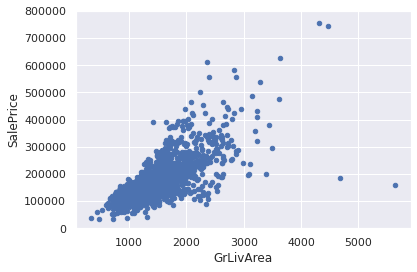

In [113]:
# Bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


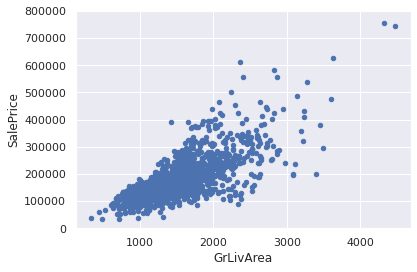

In [114]:
# Deleting outliers regarding the column 'GrLivArea'
drop_index = train_data.sort_values(by = 'GrLivArea', ascending = False)[0:2].index
train_data = train_data.drop(drop_index)

# Check
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


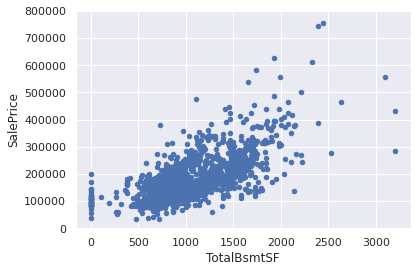

In [115]:
# Bivariate analysis saleprice/TotalBsmtSF
var = 'TotalBsmtSF'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


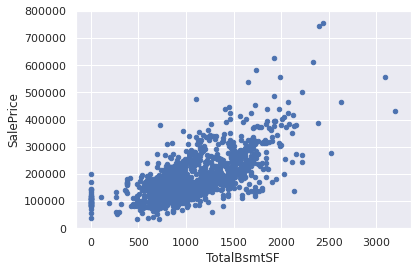

In [116]:
# Deleting outliers regarding the column 'TotalBsmtSF'
drop_index = train_data.sort_values(by = 'TotalBsmtSF', ascending = False)[0:1].index
train_data = train_data.drop(drop_index)

# Check
var = 'TotalBsmtSF'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
plt.show()

## 3.5 Handling the Skewed Features
In the first version I merged the training and test data, which leads to a data leakage. In this second version I utilized the training and test data seperately

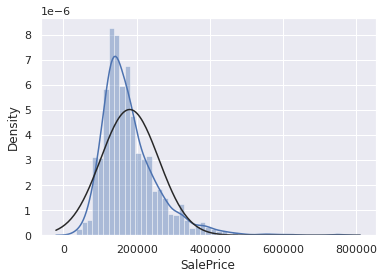

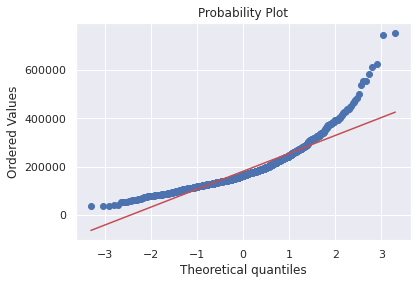

In [117]:
# Example: Histogram and normal probability plot of SalePrice
sns.distplot(train_data['SalePrice'], fit = norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot = plt)

In [118]:
data = pd.concat([train_data, test_data]).reset_index(drop = True)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2916 non-null   int64  
 1   MSSubClass     2916 non-null   object 
 2   MSZoning       2916 non-null   object 
 3   LotFrontage    2916 non-null   object 
 4   LotArea        2916 non-null   int64  
 5   Street         2916 non-null   object 
 6   LotShape       2916 non-null   object 
 7   LandContour    2916 non-null   object 
 8   Utilities      2916 non-null   object 
 9   LotConfig      2916 non-null   object 
 10  LandSlope      2916 non-null   object 
 11  Neighborhood   2916 non-null   object 
 12  Condition1     2916 non-null   object 
 13  Condition2     2916 non-null   object 
 14  BldgType       2916 non-null   object 
 15  HouseStyle     2916 non-null   object 
 16  OverallQual    2916 non-null   int64  
 17  OverallCond    2916 non-null   int64  
 18  YearBuil

Id MSSubClass MSZoning  ... SaleCondition  SalePrice TrainTest
0        1         60       RL  ...        Normal   208500.0         1
1        2         20       RL  ...        Normal   181500.0         1
2        3         60       RL  ...        Normal   223500.0         1
3        4         70       RL  ...       Abnorml   140000.0         1
4        5         60       RL  ...        Normal   250000.0         1
...    ...        ...      ...  ...           ...        ...       ...
2911  2915        160       RM  ...        Normal        NaN         0
2912  2916        160       RM  ...       Abnorml        NaN         0
2913  2917         20       RL  ...       Abnorml        NaN         0
2914  2918         85       RL  ...        Normal        NaN         0
2915  2919         60       RL  ...        Normal        NaN         0

[2916 rows x 75 columns]

In [119]:
# Select the numeric features excluding SalePrice and TrainTest
numeric = [cname for cname in train_data.columns[1:] if train_data[cname].dtype in ['int64', 'float64'] and cname != 'TrainTest']

numeric # show the numeric features

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'SalePrice']

In [120]:
data[numeric]

LotArea  OverallQual  OverallCond  ...  MiscVal  YrSold  SalePrice
0        8450            7            5  ...        0    2008   208500.0
1        9600            6            8  ...        0    2007   181500.0
2       11250            7            5  ...        0    2008   223500.0
3        9550            7            5  ...        0    2006   140000.0
4       14260            8            5  ...        0    2008   250000.0
...       ...          ...          ...  ...      ...     ...        ...
2911     1936            4            7  ...        0    2006        NaN
2912     1894            4            5  ...        0    2006        NaN
2913    20000            5            7  ...        0    2006        NaN
2914    10441            5            5  ...      700    2006        NaN
2915     9627            7            5  ...        0    2006        NaN

[2916 rows x 30 columns]

In [121]:
# Drop the ordinal values from numeric features
numeric_drop_ordinal = ['LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

# Check the skewness of all numerical features
# Handling the training and test data seperately
# Training data:
skewed_feats = train_data[numeric_drop_ordinal].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print('The skewness of training data:\n')
print(skewness)

The skewness of training data:

                    Skew
MiscVal        24.451726
PoolArea       15.943422
LotArea        12.569667
3SsnPorch      10.293487
ScreenPorch     4.117285
EnclosedPorch   3.085809
OpenPorchSF     2.339021
SalePrice       1.885088
WoodDeckSF      1.544917
GrLivArea       1.011175
BsmtUnfSF       0.921769
2ndFlrSF        0.811915
BsmtFinSF1      0.767039
TotalBsmtSF     0.438115


In [122]:
# Test data:
skewed_feats = test_data[numeric_drop_ordinal].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print('The skewness of test data:\n')
print(skewness)

The skewness of test data:

                    Skew
PoolArea       20.196888
MiscVal        20.075188
3SsnPorch      12.524216
EnclosedPorch   4.669172
ScreenPorch     3.788244
LotArea         3.115217
OpenPorchSF     2.687779
WoodDeckSF      2.130760
BsmtFinSF1      1.166330
GrLivArea       1.130402
BsmtUnfSF       0.919923
2ndFlrSF        0.912883
TotalBsmtSF     0.805066
SalePrice            NaN


In [123]:
# Log transformation: applying when skewness > 0.5
def log_transform(data):
  for num in numeric_drop_ordinal:
    if num != 'TotalBsmtSF': # Excluding feature TotalBsmtSF
      data[num] = np.log1p(data[num])
    
  # Check the skewness of all numerical features
  skewed_feats = data[numeric_drop_ordinal].skew().sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  print(skewness)

# Applying the log transformation to training data
log_transform(train_data)
    

                    Skew
PoolArea       15.512308
3SsnPorch       7.726645
MiscVal         5.164816
ScreenPorch     3.146253
EnclosedPorch   2.108812
TotalBsmtSF     0.438115
2ndFlrSF        0.291571
WoodDeckSF      0.155236
SalePrice       0.122880
OpenPorchSF    -0.024272
GrLivArea      -0.070232
LotArea        -0.180595
BsmtFinSF1     -0.617077
BsmtUnfSF      -2.184219


In [124]:
# Applying the log transformation to test data
log_transform(test_data)

                    Skew
PoolArea       15.720914
3SsnPorch      10.543859
MiscVal         5.262633
ScreenPorch     2.771785
EnclosedPorch   1.827930
TotalBsmtSF     0.805066
2ndFlrSF        0.321010
WoodDeckSF      0.162851
GrLivArea       0.028376
OpenPorchSF    -0.060337
BsmtFinSF1     -0.616148
LotArea        -0.915598
BsmtUnfSF      -2.129069
SalePrice            NaN


In [ ]:
# for item in numeric_drop_ordinal:
#     print(item)
#     fig = plt.figure()
#     sns.distplot(data[item], fit = norm)
    
#     fig = plt.figure()
#     res = stats.probplot(data[item], plot = plt)

# plt.show()

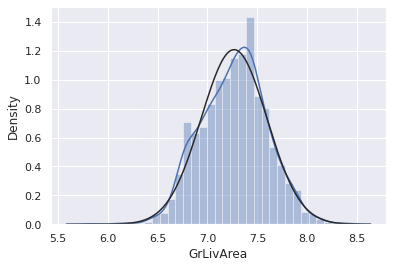

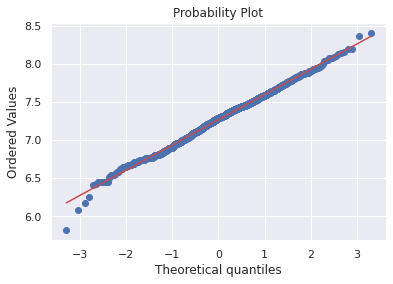

In [125]:
# Check the transformed histogram and normal probability plot GrLivArea
# Training data
sns.distplot(train_data['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

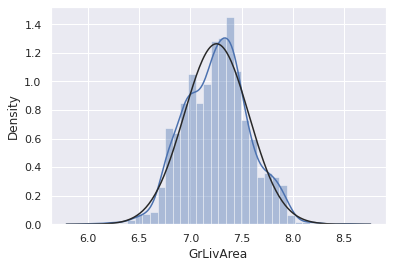

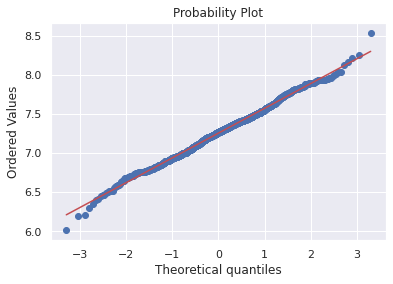

In [126]:
# Test data
sns.distplot(test_data['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(test_data['GrLivArea'], plot=plt)

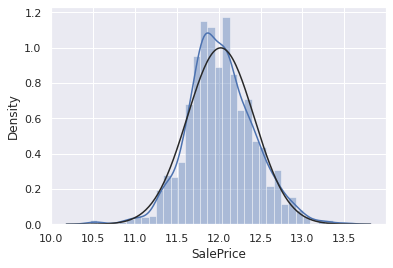

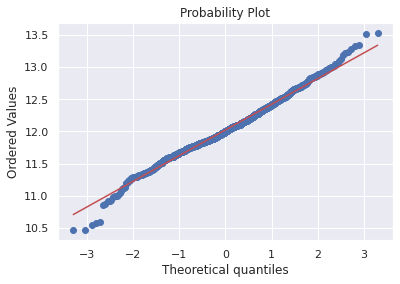

In [128]:
# Check the histogram and normal probability plot 'SalePrice'
sns.distplot(train_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

In [129]:
data = pd.concat([train_data, test_data]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2916 non-null   int64  
 1   MSSubClass     2916 non-null   object 
 2   MSZoning       2916 non-null   object 
 3   LotFrontage    2916 non-null   object 
 4   LotArea        2916 non-null   float64
 5   Street         2916 non-null   object 
 6   LotShape       2916 non-null   object 
 7   LandContour    2916 non-null   object 
 8   Utilities      2916 non-null   object 
 9   LotConfig      2916 non-null   object 
 10  LandSlope      2916 non-null   object 
 11  Neighborhood   2916 non-null   object 
 12  Condition1     2916 non-null   object 
 13  Condition2     2916 non-null   object 
 14  BldgType       2916 non-null   object 
 15  HouseStyle     2916 non-null   object 
 16  OverallQual    2916 non-null   int64  
 17  OverallCond    2916 non-null   int64  
 18  YearBuil

## 3.6 Transforming the Date Data into Age Data

In [130]:
# Features with infos of Date(Year)
year = ['YearBuilt', 'YearRemodAdd', 'YrSold'] # 'GarageYrBlt' has been already drooped

data[year]

YearBuilt  YearRemodAdd  YrSold
0          2003          2003    2008
1          1976          1976    2007
2          2001          2002    2008
3          1915          1970    2006
4          2000          2000    2008
...         ...           ...     ...
2911       1970          1970    2006
2912       1970          1970    2006
2913       1960          1996    2006
2914       1992          1992    2006
2915       1993          1994    2006

[2916 rows x 3 columns]

In [131]:
# Transforming the features 'YearBuilt' and 'YearRemodAdd' into the ages
def transform2age(data):
    data1 = data.copy()
    # Creating two age features
    data1['Age'] = data1['YrSold'] - data1['YearBuilt']
    data1['RemodAddAge'] = data1['YrSold'] - data1['YearRemodAdd']
    
    # Dropping the original year features
    data1.drop(['YearBuilt', 'YearRemodAdd'], axis=1, inplace = True)
    
    return data1

data1 = transform2age(data)

In [132]:
data1[['Age', 'RemodAddAge']]

Age  RemodAddAge
0       5            5
1      31           31
2       7            6
3      91           36
4       8            8
...   ...          ...
2911   36           36
2912   36           36
2913   46           10
2914   14           14
2915   13           12

[2916 rows x 2 columns]

## 3.7 Concerting the Catagorical Inputs into OneHotFeatures

In [133]:
# Dummy Variables: convert categorical variable into dummy
data_dummy = pd.get_dummies(data1)
data_dummy.info()

# define the train and test dataset
train_data_dummy = data_dummy[data_dummy['TrainTest'] == 1]
test_data_dummy = data_dummy[data_dummy['TrainTest'] == 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Columns: 442 entries, Id to SaleCondition_Partial
dtypes: float64(19), int64(13), uint8(410)
memory usage: 1.9 MB


In [134]:
print('training dataset with dummies: \n',train_data_dummy.describe())
print('test dataset with dummies: \n',test_data_dummy.describe())

training dataset with dummies: 
                 Id      LotArea  ...  SaleCondition_Normal  SaleCondition_Partial
count  1457.000000  1457.000000  ...           1457.000000            1457.000000
mean    730.524365     9.108492  ...              0.821551               0.084420
std     421.617685     0.513863  ...              0.383022               0.278112
min       1.000000     7.170888  ...              0.000000               0.000000
25%     366.000000     8.928110  ...              1.000000               0.000000
50%     731.000000     9.156306  ...              1.000000               0.000000
75%    1095.000000     9.358847  ...              1.000000               0.000000
max    1460.000000    12.279537  ...              1.000000               1.000000

[8 rows x 442 columns]
test dataset with dummies: 
                 Id      LotArea  ...  SaleCondition_Normal  SaleCondition_Partial
count  1459.000000  1459.000000  ...           1459.000000            1459.000000
mean   2190.

In [135]:
# Define the X_train
X_train = train_data_dummy.drop(['Id', 'SalePrice', 'TrainTest'], axis =1).values
X_train

array([[9.04204006, 7.        , 5.        , ..., 0.        , 1.        ,
        0.        ],
       [9.16962254, 6.        , 8.        , ..., 0.        , 1.        ,
        0.        ],
       [9.32821229, 7.        , 5.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [9.10974626, 7.        , 9.        , ..., 0.        , 1.        ,
        0.        ],
       [9.18173511, 5.        , 6.        , ..., 0.        , 1.        ,
        0.        ],
       [9.20412107, 5.        , 6.        , ..., 0.        , 1.        ,
        0.        ]])

In [136]:
# Define the y_train
y_train = train_data_dummy['SalePrice'].values
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

# 4. Building ML Models

In [137]:
# Set cross validation folds
kf = KFold(n_splits = 12, random_state = 20, shuffle = True)

In [138]:
# Define error metrics
# Root Mean Square Log Error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X = X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring = 'neg_mean_squared_error', cv = kf))
    return (rmse)

## 4.1 Base Models and Stacking Model

In [139]:
# Set teh random state
random_state = 20

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression',
                          num_leaves=4,
                          learning_rate=0.01, 
                          n_estimators=5000,
                          max_bin=200, 
                          bagging_fraction=0.75,
                          bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,
                          feature_fraction_seed=7,
                          verbose=-1,
                          colsample_bytree=None, 
                          subsample=None, 
                          subsample_freq=None)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01, 
                       n_estimators=3460,
                       max_depth=3, 
                       min_child_weight=0,
                       gamma=0, 
                       subsample=0.7,
                       colsample_bytree=0.7, 
                       verbosity = 1,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, 
                       seed=random_state, 
                       reg_alpha=0.00006,
                       tree_method = 'gpu_hist')

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=random_state)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=random_state)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [140]:
scores = {}

score = cv_rmse(lightgbm)
print('lightgbm: {:.4f} ({:.4f})'.format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

lightgbm: 0.1141 (0.0157)
xgboost: 0.1131 (0.0153)
SVR: 0.1375 (0.0221)
ridge: 0.1096 (0.0168)
rf: 0.1390 (0.0161)
gbr: 0.1133 (0.0155)


In [ ]:
# scores = {}

# score = cv_rmse(lightgbm)
# print('lightgbm: {:.4f} ({:.4f})'.format(score.mean(), score.std()))
# scores['lgb'] = (score.mean(), score.std())

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['xgb'] = (score.mean(), score.std())

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

# score = cv_rmse(ridge)
# print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['ridge'] = (score.mean(), score.std())

# score = cv_rmse(rf)
# print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['rf'] = (score.mean(), score.std())

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['gbr'] = (score.mean(), score.std())

lightgbm: 0.1133 (0.0159)
xgboost: 0.1120 (0.0149)
SVR: 0.1371 (0.0215)
ridge: 0.1097 (0.0161)
rf: 0.1390 (0.0161)
gbr: 0.1124 (0.0167)


In [142]:
# fit the models
print('stack_gen')
stack_gen_model = stack_gen.fit(X_train, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)
                                  
print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('RandomForest')
rf_model_full_data = rf.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)


stack_gen
lightgbm
xgboost
Svr
Ridge
RandomForest
GradientBoosting


## 4.2 Blending Model

In [155]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
  return ((0.15 * ridge_model_full_data.predict(X)) + 
          (0.05 * svr_model_full_data.predict(X)) + 
          (0.15 * gbr_model_full_data.predict(X)) + 
          (0.15 * xgb_model_full_data.predict(X)) + 
          (0.15 * lgb_model_full_data.predict(X)) + 
          (0.05 * rf_model_full_data.predict(X)) + 
          (0.3 * stack_gen_model.predict(np.array(X))))

In [156]:
# Get final precitions from the blended model
blended_score = rmsle(y_train, blended_predictions(X_train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.06024567770784739


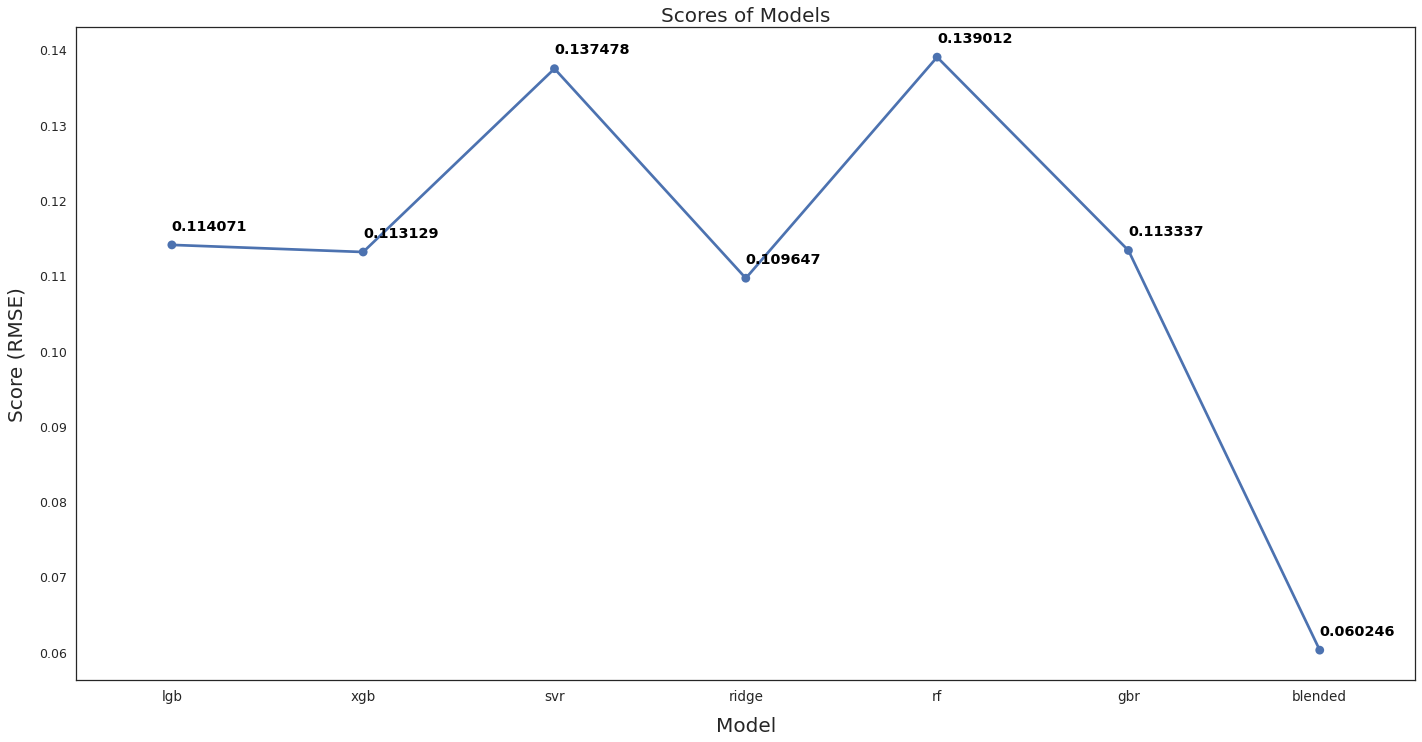

In [157]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

# 5. Prediction and Outputs

In [158]:
submission = pd.read_csv("../house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

(1459, 2)

In [159]:
X_test = test_data_dummy.drop(['Id', 'SalePrice', 'TrainTest'], axis =1).values
X_test

array([[9.36074117, 5.        , 6.        , ..., 0.        , 1.        ,
        0.        ],
       [9.56577455, 6.        , 6.        , ..., 0.        , 1.        ,
        0.        ],
       [9.53466773, 5.        , 5.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [9.90353755, 5.        , 7.        , ..., 0.        , 0.        ,
        0.        ],
       [9.25359141, 5.        , 5.        , ..., 0.        , 1.        ,
        0.        ],
       [9.1724308 , 7.        , 5.        , ..., 0.        , 1.        ,
        0.        ]])

In [160]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))

In [161]:
submission.to_csv("submissionV13.csv", index=False)

In [ ]:
# # Fix outleir predictions
# q1 = submission['SalePrice'].quantile(0.0045)
# q2 = submission['SalePrice'].quantile(0.99)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
# submission.to_csv("submissionV13.csv", index=False)